# GEOS 505: Problem Set 3

### Background:

As part of your thesis, you are using a physics-based model to predict how the timing and amount of snow water storage in the Boise River Basin will change under alternative future scenarios of climate. You have your model up and running and presented preliminary results for the first time at a recent committee meeting. One of your committee members works with the Idaho NRCS snow survey and points out that your results would be more impactful if you could present them in the context of historical observations of snow water equivalent (SWE). In particular, your committee wants you to plot your simulations on top of historical SNOTEL climatology, presented as follows: 

<img src="../img/trinity_mtn-id-wteq-por.png" alt="Trinity Mtn. SNOTEL" width="1000" style="display: block; margin: 0 auto"/>

This figure, which can be generated on the NRCS website for any SNOTEL site and many water supply basins. This particular image is the 30 year "normals" for the 1991-2020 timeframe at Trinity Mountain SNOTEL site in the Upper Boise. The plot contains a water-year oriented plot of the following items:

- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

### Problem: 

Your hypothetical task for your thesis and the task for this problem set is to reproduce the above figure in a way that would allow you to analyze and plot historical data at a variety of SNOTEL sites, and in a way that would allow you to plot the corresponding version of this plot with simulated data for a future climate. As such, the expected outcome of this notebook is code that produces an image that looks similar to the above. You may certainly use an alternative color scheme, but make sure that the elements of the plot are labeled.

The outline of the steps is provided below, along with some helpful suggestions of `numpy` and `matplotlib` functions that you will likely need.

### 1. Imports and Definitions

In [38]:
from datetime import datetime
from dataretrieval import nwis
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

startDate = '1985-10-01'
endDate = '2025-09-30'

startDate_dt = datetime.strptime(startDate, '%Y-%m-%d')
endDate_dt = datetime.strptime(endDate, '%Y-%m-%d')

# Metloom Variables
snotel_stn = '830:ID:SNTL' # Trinity Mountain Snotel Station
snotel_pnt = SnotelPointData(station_id=snotel_stn, name='TrinityMtn')

variables = [snotel_pnt.ALLOWED_VARIABLES.SWE]

### 2. Load the Data and Verify

In [39]:
df_snotel = snotel_pnt.get_daily_data(startDate_dt, endDate_dt, variables)
df_snotel


,,geometry,SWE,SWE_units,datasource
datetime,site,,,,
1985-10-01 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-02 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-03 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-04 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-05 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
...,...,...,...,...,...
2025-09-26 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-27 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-28 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS


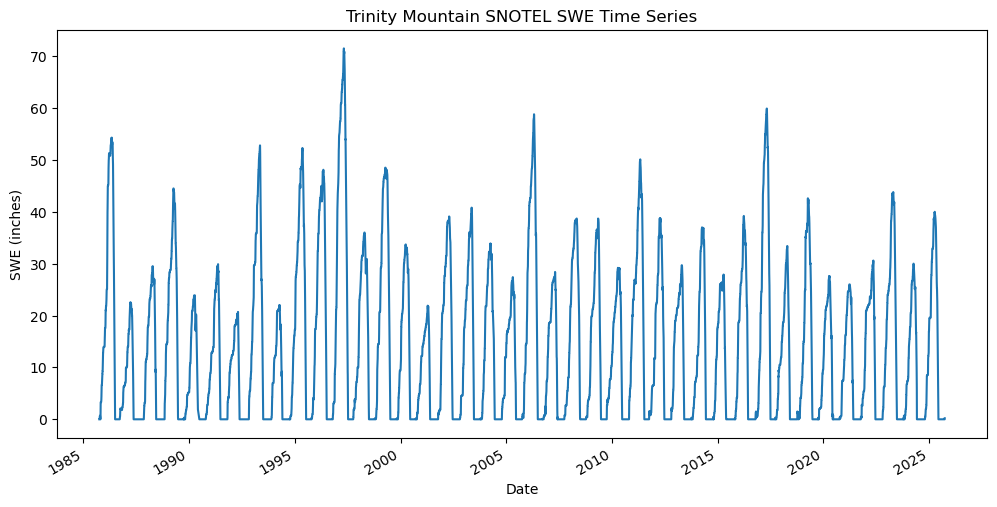

In [40]:
df_snotel.reset_index(level='site', inplace=True)
df_snotel['SWE'].plot(title='Trinity Mountain SNOTEL SWE Time Series', ylabel='SWE (inches)', xlabel='Date', figsize=(12,6))
plt.show()

In [41]:
nYears = (endDate_dt.year - startDate_dt.year)  #we don't need to add 1 because we are going from Oct 1 to Sept 30
print(nYears)  #number of water years

40


### 3. Prep Data and Preallocate Storage

In [43]:
swe_time_series = np.full((nYears, 365), np.nan) # I can't look at the full dataset but don't want to fill in zeros in case there are missing values. I'm using NaN instead.

In [44]:
print(df_snotel.columns.tolist()) #figuring out column names
print(df_snotel.index) #'datetime' did not appear, so I checked index
df_snotel=df_snotel.reset_index() #reset index to make 'datetime' a column
df_snotel['datetime'] = pd.to_datetime(df_snotel['datetime']) #ensure 'datetime' is datetime type
print(df_snotel['datetime'].dtypes) #checking datatype of 'datetime' column

['site', 'geometry', 'SWE', 'SWE_units', 'datasource']
DatetimeIndex(['1985-10-01 08:00:00+00:00', '1985-10-02 08:00:00+00:00',
               '1985-10-03 08:00:00+00:00', '1985-10-04 08:00:00+00:00',
               '1985-10-05 08:00:00+00:00', '1985-10-06 08:00:00+00:00',
               '1985-10-07 08:00:00+00:00', '1985-10-08 08:00:00+00:00',
               '1985-10-09 08:00:00+00:00', '1985-10-10 08:00:00+00:00',
               ...
               '2025-09-21 08:00:00+00:00', '2025-09-22 08:00:00+00:00',
               '2025-09-23 08:00:00+00:00', '2025-09-24 08:00:00+00:00',
               '2025-09-25 08:00:00+00:00', '2025-09-26 08:00:00+00:00',
               '2025-09-27 08:00:00+00:00', '2025-09-28 08:00:00+00:00',
               '2025-09-29 08:00:00+00:00', '2025-09-30 08:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=14559, freq=None)
datetime64[ns, UTC]


In [45]:
df_snotel['SWE_mm'] = df_snotel['SWE'] * 25.4  # Convert inches to mm

WY=df_snotel['datetime'].dt.year.values #trying to create water year column
mo=df_snotel['datetime'].dt.month.values #assign month values
WY[mo>=10] +=1  # For months Oct, Nov, Dec, increment water year by 1
df_snotel['WY']=WY #putting water year into dataframe
print(df_snotel.head()) #checking new dataframe with water year column and SWE in mm column

                   datetime         site                            geometry  \
0 1985-10-01 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
1 1985-10-02 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
2 1985-10-03 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
3 1985-10-04 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
4 1985-10-05 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   

   SWE SWE_units datasource  SWE_mm    WY  
0  0.0        in       NRCS     0.0  1986  
1  0.0        in       NRCS     0.0  1986  
2  0.0        in       NRCS     0.0  1986  
3  0.0        in       NRCS     0.0  1986  
4  0.0        in       NRCS     0.0  1986  


In [46]:
def wyd (row): #giving each day of the water year a value from 1-365 starting Oct 1
    date = row['datetime']
    if date.month >= 10:
        return date.timetuple().tm_yday -273 # Water year day starts Oct 1
    else:
        return date.timetuple().tm_yday + 92 # Adjust for Jan 1 to Sep 30
    
df_snotel['WYD'] = df_snotel.apply(wyd, axis=1) #applying function to dataframe and creating new column WYD
print(df_snotel.head()) #checking new dataframe with WYD column

                   datetime         site                            geometry  \
0 1985-10-01 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
1 1985-10-02 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
2 1985-10-03 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
3 1985-10-04 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   
4 1985-10-05 08:00:00+00:00  830:ID:SNTL  POINT Z (-115.43818 43.62903 7790)   

   SWE SWE_units datasource  SWE_mm    WY  WYD  
0  0.0        in       NRCS     0.0  1986    1  
1  0.0        in       NRCS     0.0  1986    2  
2  0.0        in       NRCS     0.0  1986    3  
3  0.0        in       NRCS     0.0  1986    4  
4  0.0        in       NRCS     0.0  1986    5  


In [47]:
#get rid of 366th day in leap years
df_snotel = df_snotel[df_snotel['WYD'] <= 365]
leap_wy=df_snotel[df_snotel['WY']==2020]
print(leap_wy) #checking to see if 366th day is gone (sept 30, 2020 should be gone)

                       datetime         site  \
12367 2019-10-01 08:00:00+00:00  830:ID:SNTL   
12368 2019-10-02 08:00:00+00:00  830:ID:SNTL   
12369 2019-10-03 08:00:00+00:00  830:ID:SNTL   
12370 2019-10-04 08:00:00+00:00  830:ID:SNTL   
12371 2019-10-05 08:00:00+00:00  830:ID:SNTL   
...                         ...          ...   
12727 2020-09-25 08:00:00+00:00  830:ID:SNTL   
12728 2020-09-26 08:00:00+00:00  830:ID:SNTL   
12729 2020-09-27 08:00:00+00:00  830:ID:SNTL   
12730 2020-09-28 08:00:00+00:00  830:ID:SNTL   
12731 2020-09-29 08:00:00+00:00  830:ID:SNTL   

                                 geometry  SWE SWE_units datasource  SWE_mm  \
12367  POINT Z (-115.43818 43.62903 7790)  0.0        in       NRCS    0.00   
12368  POINT Z (-115.43818 43.62903 7790)  0.0        in       NRCS    0.00   
12369  POINT Z (-115.43818 43.62903 7790)  0.3        in       NRCS    7.62   
12370  POINT Z (-115.43818 43.62903 7790)  0.0        in       NRCS    0.00   
12371  POINT Z (-115.43818 4

In [48]:
unique_WY = df_snotel['WY'].unique()
print(unique_WY) #checking unique water years
print(len(unique_WY)) #checking number of unique water years

[1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
40


In [51]:
row = 0 #start my row assignment counter
for wy in unique_WY:
    df_wy = df_snotel[df_snotel['WY'] == wy] #filter dataframe for current water year for each loop
    swe_time_series[row, :len(df_wy)] = df_wy['SWE_mm'].values #assign SWE values to swe_time_series array for current water year
    row += 1 #increment row counter by 1

print(swe_time_series) #checking array
print(swe_time_series.shape) #checking array dimensions
print(swe_time_series[39, :10]) #checking first 10 values of last water year (2025)
print(np.where(np.all(swe_time_series == 0, axis=1))) #checking for any rows that are all zeros
print(np.any(np.isnan(swe_time_series))) #checking for any NaN values in array

[[ 0.    0.    0.   ... 45.72 48.26 50.8 ]
 [53.34 50.8  50.8  ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    5.08]]
(40, 365)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(array([], dtype=int64),)
True


ChatGPT helped me do all of that, but one thing that I changed from the original approach was creating an array full of NaN instead of 0s. I was worried about missing data. If I used 0s to start and overprinted, I wouldn't know which 0s were true measurements and which ones were gaps in data. These gaps in data would be counted when finding mean, median, and percentiles, which I definitely don't want! So I made them all NaN so they will be skipped when doing these computations.

### 4. Analyze Data

In [ ]:
swe_min=np.nanmin(swe_time_series, axis=0) #min value for each day of water year across all years
swe_max=np.nanmax(swe_time_series, axis=0) #max value for each day of water year across all years
swe_median=np.nanmedian(swe_time_series, axis=0) #median value for each day of water year across all years

print('shapes', swe_min.shape, swe_max.shape, swe_median.shape) #checking shapes of output arrays
print( 'Jan 1-10 values median', swe_median[92:102]) #checking first 10 values of median array

peak_day=np.nanargmax(swe_median)
peak_value=swe_median[peak_day]
print('median peak SWE day', peak_day)
print('median peak SWE value (mm)', peak_value)

shapes (365,) (365,) (365,)
Jan 1-10 values median [367.03 382.27 389.89 391.16 412.75 439.42 447.04 448.31 448.31 448.31]
median peak SWE day 198
median peak SWE value (mm) 908.05


Apparently the median day for max swe is the 198th day of the water year. This corresponds to the 106th day of the calendar year, April 16. I checked this against the USDA plot that is our model, and mid-April for peak swe is believable. I think my data is right.

In [58]:
swe_p20=np.nanpercentile(swe_time_series, 20, axis=0) #20th percentile for each day of water year across all years
swe_p40=np.nanpercentile(swe_time_series, 40, axis=0) #40th percentile for each day of water year across all years
swe_p60=np.nanpercentile(swe_time_series, 60, axis=0) #60th percentile for each day of water year across all years
swe_p80=np.nanpercentile(swe_time_series, 80, axis=0) #80th percentile for each day of water year across all years

print('shapes', swe_p20.shape, swe_p40.shape, swe_p60.shape, swe_p80.shape) #checking shapes of output arrays

check = 198 #median peak swe day
print ('min at peak swe', swe_min[check])
print ('20th percentile at peak swe', swe_p20[check])
print ('40th percentile at peak swe', swe_p40[check])
print ('median at peak swe', swe_median[check])
print ('60th percentile at peak swe', swe_p60[check])
print ('80th percentile at peak swe', swe_p80[check])
print ('max at peak swe', swe_max[check])

swe_198=swe_time_series[:, check]
lowest_index=np.nanargmin(swe_198)
lowest_value=swe_198[lowest_index]
lowest_wy=unique_WY[lowest_index]
print('lowest SWE year', lowest_wy)
print('lowest SWE value (mm)', lowest_value)

shapes (365,) (365,) (365,) (365,)
min at peak swe 495.29999999999995
20th percentile at peak swe 690.372
40th percentile at peak swe 766.572
median at peak swe 908.05
60th percentile at peak swe 942.3399999999999
80th percentile at peak swe 1108.9640000000002
max at peak swe 1711.96
lowest SWE year 1990
lowest SWE value (mm) 495.29999999999995


Yay, the data analysis looks good! Numbers go low to high as they should. I cross-checked this with April 17 values from Trinity Mountain Snotel site. On April 17, 2023, SWE was 43 in = 1092.2 mm. On April 17, 2015, SWE was 28 in = 711 mm. The min value should be 495 mm on April 17, 1990. The website says 19.5 in = 495 mm, so we're all good.

### 5. Create Plot

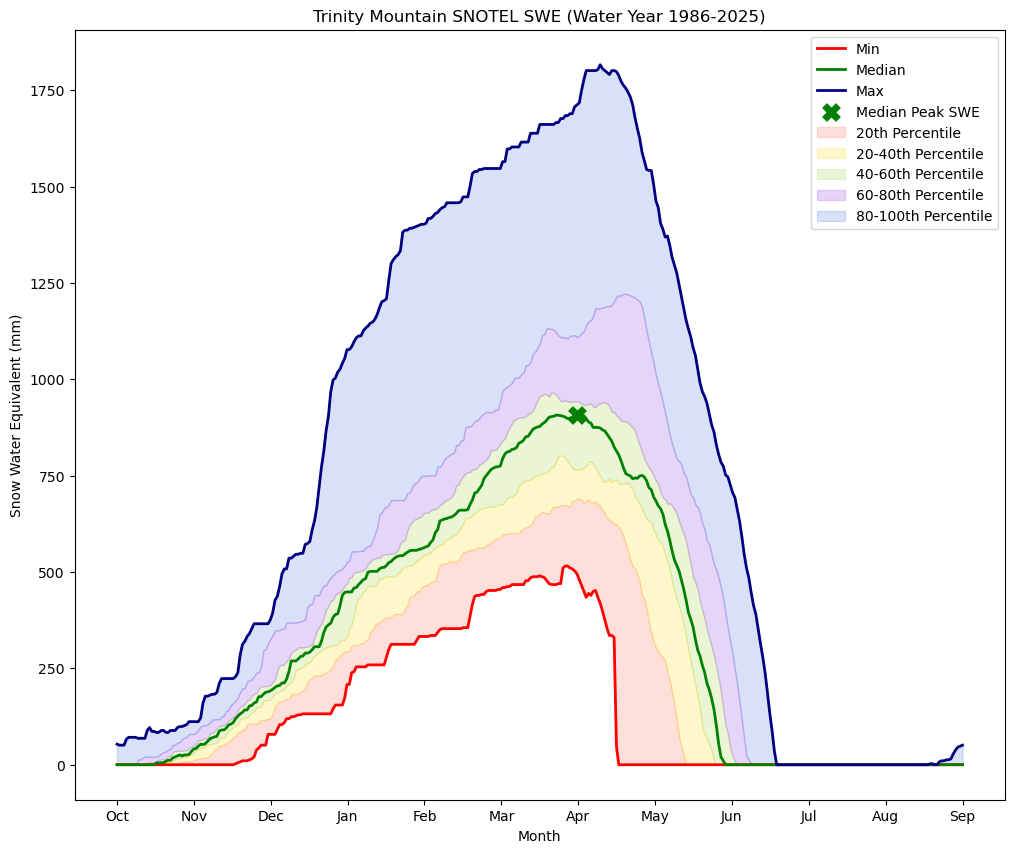

In [72]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(swe_min, label='Min', color='red', linewidth=2)
ax.plot(swe_median, label='Median', color='green', linewidth=2)
ax.plot(swe_max, label='Max', color='navy', linewidth=2)

ax.scatter(peak_day, peak_value, color='green', marker='x', s=100, linewidth=5, label='Median Peak SWE', zorder=5)

ax.fill_between(np.arange(365), swe_min, swe_p20, color='tomato', alpha=0.2, label='20th Percentile')
ax.fill_between(np.arange(365), swe_p20, swe_p40, color='gold', alpha=0.2, label='20-40th Percentile')
ax.fill_between(np.arange(365), swe_p40, swe_p60, color='yellowgreen', alpha=0.2, label='40-60th Percentile')
ax.fill_between(np.arange(365), swe_p60, swe_p80, color='blueviolet', alpha=0.2, label='60-80th Percentile')
ax.fill_between(np.arange(365), swe_p80, swe_max, color='royalblue', alpha=0.2, label='80-100th Percentile')

month_labels=['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
ax.set_xticks(np.linspace(0, 364, num=12))
ax.set_xticklabels(month_labels)

ax.set_ylabel('Snow Water Equivalent (mm)')
ax.set_xlabel('Month')
ax.set_title('Trinity Mountain SNOTEL SWE (Water Year 1986-2025)')
ax.legend(loc='upper right')

plt.show()